<div style="width: 30%; float: right; margin: 10px; margin-right: 5%;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/FHNW_Logo.svg/2560px-FHNW_Logo.svg.png" width="500" style="float: left; filter: invert(50%);"/>
</div>

<h1 style="text-align: left; margin-top: 10px; float: left; width: 60%;">
    del Mini-Challenge 2 <br> 
</h1>

<p style="clear: both; text-align: left;">
    Bearbeitet durch Si Ben Tran im HS 2023.<br>Bachelor of Science FHNW in Data Science.
</p>


Ziel:  
Vertiefung in ein eher aktuelles Paper aus der Forschung und Umsetzung eines darin beschriebenen oder verwandten Tasks - gemäss Vereinbarung mit dem Fachcoach. 

Beispiel:  
Implementiere, trainiere und validiere ein Deep Learning Modell für Image Captioning wie beschrieben im Paper Show and Tell.

Zeitlicher Rahmen:  
Wird beim Schritt 1 verbindlich festgelegt.

Beurteilung:  
Beurteilt wird auf Basis des abgegebenen Notebooks:  
•	Vollständige und korrekte Umsetzung der vereinbarten Aufgabestellung.  
•	Klare, gut-strukturierte Umsetzung.   
•	Schlüssige Beschreibung und Interpretation der Ergebnisse. Gut gewählte und gut kommentierten Plots und Tabellen.  
•	Vernünftiger Umgang mit (Computing-)Ressourcen.  
•	Verständliche Präsentation der Ergebnisse.  

Referenzen, Key Words  
•	Word Embedding (z.B. word2vec, glove), um Wörter in numerische Vektoren in einem geeignet dimensionierten Raum zu mappen. Siehe z.B. Andrew Ng, Coursera: [Link](https://www.coursera.org/lecture/nlp-sequence-models/learning-word-embeddings-APM5s)      
•	Bild Embedding mittels vortrainierten (evt. retrained) Netzwerken wie beispielsweise ResNet, GoogLeNet, EfficientNet oder ähnlich Transfer-Learning.  
•	Seq2Seq Models bekannt für Sprach-Übersetzung. 

Daten:   
•	Gemäss Vereinbarung (für Captioning: [Flickr8k-Daten](https://www.kaggle.com/adityajn105/flickr8k/activity)).

•	Absprache/Beschluss mit Coach und Beschluss, was evaluiert werden soll.
 

# 1 Setup und Imports

In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

# path setup
import os
os.chdir('../')

# Data Science Libraries
import tqdm 
from tqdm import tqdm 
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from multiprocessing import cpu_count
import random


# Text Processing
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from typing import List

# Torch
import torch
print(torch.__version__)
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence
from torch.utils.data import Dataset
from torchvision.models import ResNet18_Weights
from torchvision import models
from torchvision.transforms import Compose, CenterCrop, Resize, ToTensor, ToPILImage, Normalize
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, RandomVerticalFlip, ColorJitter
import pytorch_lightning as pl 
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger

import wandb

# Custom Modules
from src.gpu_setup import DeviceSetup





1.13.1+cu116


c:\Users\Ben\venvs\del\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
device_setup = DeviceSetup(seed=42)
device_setup.setup()

Using device: cuda

NVIDIA GeForce GTX 980
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


---

# 2 Daten
Wir erkennen bei der Spalte *image*, das ein jpg. Bilddatei mehrere *catpion* hat.

Bei der Visualisierung der Bilder erkenne wir:
- Personen oder Tiere
- Unterschiedliche Grössen
- Unterschiedliche Auflösung


In [3]:
class DataExplorer:
    def __init__(self, image_path, captions_path):
        self.image_path = image_path
        self.data = pd.read_csv(captions_path)


    def _get_image_unique(self):
        """
        This method returns a list of unique image IDs.
        """
        image_unique = self.data['image'].unique()
        return image_unique
    
    def _get_word_counts(self):
        """
        This method returns a list of the number of words per caption.
        """
        word_counts = self.data['caption'].apply(str.split).apply(len)
        return word_counts
    
    def _read_image(self, image_id):
        """
        This method reads an image from a specific path and returns the image object.
        """
        image = Image.open(self.image_path + "/" + image_id)
        return image

    def _get_captions(self, image_id):
        """
        This method retrieves the captions associated with an image ID from the data dictionary.
        """
        captions = []
        for i in range(len(self.data)):
            if self.data['image'][i] == image_id:
                captions.append(self.data['caption'][i])
        captions = '\n'.join(captions)
        return captions

    def plot_n_m_image_caption(self, n, m):
        """
        This method plots a grid of n x m images along with their captions.
        """
        image_unique = self._get_image_unique()
        fig, ax = plt.subplots(n, m, figsize=(16, 20))
        for i in range(n):
            for j in range(m):
                index = np.random.randint(0, len(image_unique))
                image_id = image_unique[index]
                image = self._read_image(image_id)
                captions = self._get_captions(image_id)
                ax[i, j].imshow(np.asarray(image))
                ax[i, j].set_title(captions)
        plt.tight_layout()
        plt.show()

    def plot_image_size(self):
        """
        This method plots a grid of n x m images along with their captions.
        """
        image_unique = self._get_image_unique()
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        # set range of x and y axis
        ax.set_xlabel('width of image')
        ax.set_ylabel('height of image')
        for i in range(len(image_unique)):
            image_id = image_unique[i]
            image = self._read_image(image_id)
            width, height = image.size
            ax.scatter(width, height)
        ax.set_title('Distribution size of images')
        plt.tight_layout()
        plt.show()

    # plot caption distribution word length
    def plot_caption_distribution(self):
        """
        This method plots the distribution of the number of words per caption.
        """
        word_counts = self._get_word_counts()
        plt.figure(figsize=(12, 8))
        plt.hist(word_counts, bins=25, color = 'limegreen', edgecolor='black', linewidth=1.2)
        plt.title("Distribution of Number of Words per Caption")
        plt.xlabel("Number of Words")
        plt.ylabel("Frequency")
        plt.show()

    # get statistical summary of caption distribution word length
    def get_caption_distribution(self):
        """
        This method prints the statistical summary of the number of words per caption.
        """
        word_counts = self._get_word_counts()
        print(word_counts.describe(percentiles=[0.25, 0.5, 0.75, 0.95]))

    def plot_caption_ecdf(self):
        """
        This method plots the ECDF of the number of words per caption.
        """
        word_counts = self._get_word_counts()
        word_counts_sorted = word_counts.sort_values()
        y = np.arange(1, len(word_counts_sorted) + 1) / len(word_counts_sorted)  
        plt.figure(figsize=(12, 8))
        plt.plot(word_counts_sorted, y, color='limegreen')
        plt.axhline(y=0.95, color='r', linestyle='-')
        plt.axvline(x=19, color='r', linestyle='-')
        plt.xticks(np.arange(np.min(word_counts_sorted), np.max(word_counts_sorted), 1.0))
        plt.title("ECDF of Number of Words per Caption")
        plt.xlabel("Number of Words")
        plt.ylabel("Proportion")
        plt.show()

    # plot most commen words
    def plot_most_common_words(self):
        """
        This method plots the most common words in the captions.
        """
        from collections import Counter
        word_counts = self.data['caption'].apply(str.split).apply(Counter).sum()
        word_counts = pd.DataFrame.from_dict(word_counts, orient='index').reset_index()
        word_counts.columns = ['word', 'count']
        word_counts = word_counts.sort_values(by='count', ascending=False)
        plt.figure(figsize=(12, 8))
        plt.bar(word_counts['word'][:20], word_counts['count'][:20], color = 'limegreen', edgecolor='black', linewidth=1.2)
        plt.title("Most Common Words in Captions")
        plt.xlabel("Words")
        plt.ylabel("Frequency")
        plt.xticks(rotation=45)
        plt.show()

In [4]:
image_path = "data/Flickr8K/images/"
captions_path = "data/Flickr8K/captions.txt"

flicker_data_explorer = DataExplorer(image_path, captions_path)
flicker_data = flicker_data_explorer.data

## 2.1 Dataframe

In [5]:
flicker_data

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


## 2.2 Visualisierungen der Bilder

In [6]:
#flicker_data_explorer.plot_n_m_image_caption(2, 2)

## 2.3 Grössen der Bilder

In [7]:
#flicker_data_explorer.plot_image_size()

## 2.4 Caption Länge

In [8]:
#flicker_data_explorer.plot_caption_distribution()
#flicker_data_explorer.plot_caption_ecdf()
#flicker_data_explorer.get_caption_distribution()

## 2.5 Häufigste Wörter

In [9]:
#flicker_data_explorer.plot_most_common_words()

---

# 3 Preprocessing der Bilder

Wir werden Die Bilder wie folgt vorbereiten, damit das Model die Bilder verarbeiten kann: 

`ToPILImage()`: Dieser Schritt konvertiert das Eingabebild in ein PIL (Python Imaging Library) Bildformat. Dies ist erforderlich, wenn das Eingabebild nicht bereits im PIL-Format vorliegt.

`CenterCrop((500, 500))`: Hier wird das Bild auf eine Größe von 500x500 Pixel zentriert zugeschnitten. Dies ist nützlich, um das Bild auf eine bestimmte Größe zu bringen und sicherzustellen, dass wichtige Merkmale in der Mitte erhalten bleiben.

`Resize((224, 224))`: Das Bild wird auf eine Größe von 224x224 Pixel skaliert. Dies ist eine häufig verwendete Größe für viele neuronale Netzwerke, insbesondere in der Bildklassifikation, wie z.B. Convolutional Neural Networks (CNNs).

`ToTensor()`: Hier wird das Bild in einen PyTorch-Tensor konvertiert. Die meisten neuronalen Netzwerke in PyTorch und anderen Frameworks arbeiten mit Tensoren als Eingabe.

`Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`: Diese Transformation normalisiert die Pixelwerte des Bildes. Dies ist wichtig, um sicherzustellen, dass die Werte im Eingangsbild in einem bestimmten Bereich liegen. Die angegebenen Mittelwerte und Standardabweichungen sind typische Werte für die Normalisierung von Bildern, die auf dem ImageNet-Datensatz trainiert wurden.

`RandomHorizontalFlip`: Führt mit einer Wahrscheinlichkeit von `horizontal_flip_prob` eine zufällige horizontale Spiegelung des Bildes durch.

`RandomVerticalFlip`: Führt mit einer Wahrscheinlichkeit von `vertical_flip_prob` eine zufällige vertikale Spiegelung des Bildes durch.

`RandomRotation`: Führt eine zufällige Rotation des Bildes um den angegebenen Winkel (`rotation_degree` Grad) durch.

`ColorJitter`: Verändert die Helligkeit, den Kontrast, die Sättigung und den Farbton des Bildes zufällig, um die Farbvariationen zu erhöhen.

In [10]:
target_size = (224, 224)
center_crpp = (500, 500)
mean_values = [0.485, 0.456, 0.406]
std_values = [0.229,0.224,0.225]

image_transformations = Compose([
    CenterCrop(center_crpp),
    Resize(target_size),
    ToTensor(),
    Normalize(mean=mean_values,
                std=std_values)
])

rotation_degree = 45
horizontal_flip_prob = 0.5
vertical_flip_prob = 0.5

image_transforms_augmented = Compose([
    RandomHorizontalFlip(p=horizontal_flip_prob),
    RandomVerticalFlip(p=vertical_flip_prob),
    RandomRotation(degrees=rotation_degree),
    ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    CenterCrop(center_crpp),
    Resize(target_size),
    ToTensor(),
    Normalize(mean=mean_values,
                std=std_values)
])


image_inverse_transformations = Compose([
     Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                 std=[1/0.229, 1/0.224, 1/0.225])
])


## 3.1 Test der Transformationen

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


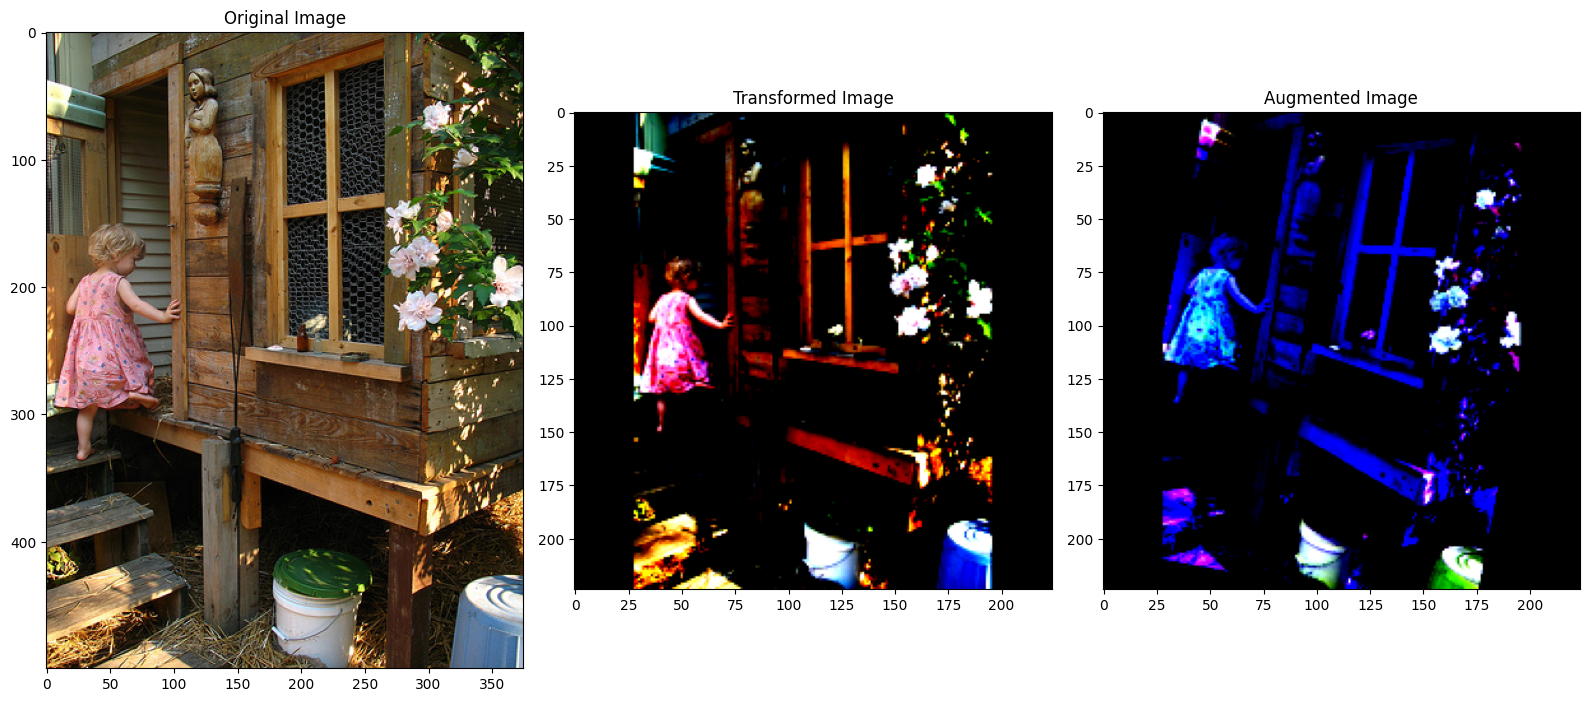

In [11]:
# Show transformation on sample image
image_id = flicker_data['image'][0]
image = flicker_data_explorer._read_image(image_id)
image_transformed = image_transformations(image)
image_transformed_augmented = image_transforms_augmented(image)

fig, ax = plt.subplots(1, 3, figsize=(16, 8))
ax[0].imshow(np.asarray(image))
ax[0].set_title('Original Image')
ax[1].imshow(np.transpose(image_transformed, (1, 2, 0)))
ax[1].set_title('Transformed Image')
ax[2].imshow(np.transpose(image_transformed_augmented, (1, 2, 0)))
ax[2].set_title('Augmented Image')
plt.tight_layout()
plt.show()



---

# 4 PreProcessing von Captions
Die gezeigte Python-Klasse `PreprocessCaption` dient der Vorverarbeitung von Bildunterschriften (captions) in natürlicher Sprache.

Konstruktor `__init__`:

Der Konstruktor dieser Klasse wird beim Erstellen eines Objekts aufgerufen und hat einen optionalen Parameter `threshold`, der auf den Wert 2 eingestellt ist. Dieser Schwellenwert dient dazu, die Wörter in der Vokabelliste zu filtern. Die Klasse hat außerdem einige Instanzvariablen, darunter `threshold`, `vocab`, `word_to_index`, `index_to_word`, `freq_dist` und `special_tokens`. 

- `threshold`: Der Schwellenwert zur Auswahl der Wörter im Vokabular basierend auf ihrer Häufigkeit.
- `vocab`: Eine Liste, die das Vokabular enthält.
- `word_to_index`: Ein Wörterbuch, das Wörter auf ihre Indexpositionen im Vokabular abbildet.
- `index_to_word`: Ein Wörterbuch, das Indexpositionen auf die entsprechenden Wörter im Vokabular abbildet.
- `freq_dist`: Eine Instanz von `FreqDist` aus der NLTK-Bibliothek, die die Häufigkeit der Wörter im Text speichert.
- `special_tokens`: Eine Liste von speziellen Tokens wie '<START>', '<END>', '<PAD>' und '<UNK>', die oft in NLP-Aufgaben verwendet werden.

`create_vocabulary`:
Diese Methode erstellt das Vokabular basierend auf den übergebenen Daten in Form eines Pandas DataFrame. Sie tokenisiert zuerst alle Bildunterschriften, filtert Wörter nach ihrer Häufigkeit unter Verwendung des Schwellenwerts und fügt schließlich die speziellen Tokens zum Vokabular hinzu. Das Ergebnis wird in den Instanzvariablen `vocab`, `word_to_index` und `index_to_word` gespeichert.

`get_vocab`:
Diese Methode gibt das Vokabular als Liste von Wörtern zurück.

`get_vocab_size`:
Diese Methode gibt die Größe des Vokabulars zurück, dh die Anzahl der eindeutigen Wörter im Vokabular.

`get_word_to_index`:
Diese Methode gibt das Wörterbuch zurück, das Wörter auf ihre Indexpositionen im Vokabular abbildet.

`get_index_to_word`:
Diese Methode gibt das Wörterbuch zurück, das Indexpositionen auf die entsprechenden Wörter im Vokabular abbildet.

`caption_to_tokens`:
Diese Methode konvertiert eine Bildunterschrift in eine Liste von Token-Indizes unter Verwendung des erstellten Vokabulars. Die Tokens werden in der Reihenfolge '<START>', gefolgt von den Token-Indizes der Wörter in der Bildunterschrift und schließlich '<END>' zurückgegeben.

`tokens_to_caption`:
Diese Methode konvertiert eine Liste von Token-Indizes zurück in eine menschenlesbare Bildunterschrift, indem sie die Wörter aus dem Vokabular extrahiert und sie in der richtigen Reihenfolge anordnet, bis '<END>' erreicht wird. Dabei werden spezielle Tokens wie '<START>' und '<END>' ignoriert.

Die Klasse `PreprocessCaption` ermöglicht es, Textdaten für die Verwendung in Machine Learning- oder Deep Learning-Modellen vorzubereiten, insbesondere für Aufgaben im Bereich des maschinellen Sehens (Computer Vision), bei denen Bildunterschriften verarbeitet werden müssen.


In [12]:
class PreprocessCaption:
    def __init__(self, threshold: int = 0):
        self.threshold = threshold
        self.vocab = []
        self.word_to_index = {}
        self.index_to_word = {}
        self.freq_dist = None
        self.special_tokens = ['<START>', '<END>', '<PAD>', '<UNK>']

    def get_vocab(self) -> List[str]:
        return self.vocab

    def get_vocab_size(self) -> int:
        return len(self.vocab)
    
    def get_word_to_index(self) -> dict:
        return self.word_to_index
    
    def get_index_to_word(self) -> dict:
        return self.index_to_word

    def create_vocabulary(self, data: pd.DataFrame) -> None:
        all_captions = " ".join(data["caption"].values)
        words = word_tokenize(all_captions.lower())
        words = [word for word in words if word.isalpha()]
        self.freq_dist = FreqDist(words)

        self.vocab = [word for word, freq in self.freq_dist.items() if freq >= self.threshold]
        self.vocab = self.special_tokens + self.vocab
        self.word_to_index = {word: idx for idx, word in enumerate(self.vocab)}
        self.index_to_word = {idx: word for idx, word in enumerate(self.vocab)}

    def caption_to_tokens(self, caption: str) -> List[int]:
        if not caption:
            return []
        tokens = word_tokenize(caption.lower())
        tokenized_caption = [self.word_to_index.get('<START>')]
    
        for token in tokens:
            tokenized_caption.append(self.word_to_index.get(token, self.word_to_index.get('<UNK>')))
    
        tokenized_caption.append(self.word_to_index.get('<END>'))
        return tokenized_caption

    def tokens_to_caption(self, tokens: List[int]) -> str:
        words = []
        for idx in tokens:
            word = self.index_to_word.get(idx)
            if word == '<END>':
                break
            if word and word not in self.special_tokens:
                words.append(word)
        return ' '.join(words)


## 4.1 Test Preprocessing der Captions 

In [13]:
# Initialize VocabularyBuilder
caption_info = PreprocessCaption(threshold=0)

# Create vocabulary
caption_info.create_vocabulary(flicker_data)

# Get vocabulary and its size
vocab = caption_info.get_vocab()
vocab_size = caption_info.get_vocab_size()

print("Vocabulary Size:", vocab_size)
print("Vocabulary:", vocab)
print()

# Get word_to_index and index_to_word
word_to_index = caption_info.get_word_to_index()
index_to_word = caption_info.get_index_to_word()

print("Word to Index:", word_to_index)
print("Index to Word:", index_to_word)
print()

# Call caption_to_tokens and tokens_to_caption methods
caption = "A black 43$#1 dog is running towards 34 pebsi the 0.5 old grey 18 cat"
tokens = caption_info.caption_to_tokens(caption)
print("Tokens:", tokens)
print()

reconstructed_caption = caption_info.tokens_to_caption(tokens)
print("Reconstructed Caption:", reconstructed_caption)
print()

# get token from PAD
pad_token = word_to_index.get('<PAD>')
print("PAD Token:", pad_token)

Vocabulary Size: 8375
Vocabulary: ['<START>', '<END>', '<PAD>', '<UNK>', 'a', 'child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs', 'an', 'entry', 'way', 'girl', 'going', 'into', 'wooden', 'building', 'little', 'playhouse', 'the', 'to', 'her', 'cabin', 'black', 'dog', 'and', 'spotted', 'are', 'fighting', 'playing', 'with', 'each', 'other', 'on', 'road', 'white', 'brown', 'spots', 'staring', 'at', 'street', 'two', 'dogs', 'different', 'breeds', 'looking', 'pavement', 'moving', 'toward', 'covered', 'paint', 'sits', 'front', 'painted', 'rainbow', 'hands', 'bowl', 'sitting', 'large', 'small', 'grass', 'plays', 'fingerpaints', 'canvas', 'it', 'there', 'pigtails', 'painting', 'young', 'outside', 'man', 'lays', 'bench', 'while', 'his', 'by', 'him', 'which', 'also', 'tied', 'sleeping', 'next', 'shirtless', 'lies', 'park', 'laying', 'holding', 'leash', 'ground', 'orange', 'hat', 'starring', 'something', 'wears', 'glasses', 'gauges', 'wearing', 'blitz', 'beer', 'can', 'c

## 4.2 Test Preprocessing der Captions mit Trim und Padding

In [14]:
caption_to_pad = "a girl running around a tree"
caption_to_trim = "A girl running around a tree while playing with a dog and cat in the great big field of grass and flowers next to the river"

print("Caption to Pad:", caption_to_pad)
print("Caption to Trim:", caption_to_trim)
print()

max_length = 20
caption_to_pad_tokens = caption_info.caption_to_tokens(caption_to_pad)
caption_to_trim_tokens = caption_info.caption_to_tokens(caption_to_trim)

print("Caption to Pad Tokenized:", caption_to_pad_tokens)
print("Caption to Trim Tokenized:", caption_to_trim_tokens)
print()

padded_caption = caption_to_pad_tokens + [pad_token] * (max_length - len(caption_to_pad_tokens))
trimmed_caption = caption_to_trim_tokens[:max_length]

print(f"Padded Caption: {padded_caption},\n Length: {len(padded_caption)}")
print(f"Trimmed Caption: {trimmed_caption},\n Length: {len(trimmed_caption)}")



Caption to Pad: a girl running around a tree
Caption to Trim: A girl running around a tree while playing with a dog and cat in the great big field of grass and flowers next to the river

Caption to Pad Tokenized: [0, 4, 18, 119, 242, 4, 172, 1]
Caption to Trim Tokenized: [0, 4, 18, 119, 242, 4, 172, 79, 35, 36, 4, 30, 31, 1246, 6, 25, 1918, 237, 179, 13, 66, 31, 1107, 87, 26, 25, 429, 1]

Padded Caption: [0, 4, 18, 119, 242, 4, 172, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
 Length: 20
Trimmed Caption: [0, 4, 18, 119, 242, 4, 172, 79, 35, 36, 4, 30, 31, 1246, 6, 25, 1918, 237, 179, 13],
 Length: 20


---

# 5 Dataset Vorbereitung

Beschreibung der ImageCaptionDataset-Klasse

Die `ImageCaptionDataset`-Klasse ist eine Implementierung eines PyTorch-Datensatzes, der dazu dient, Daten für das Show-and-Tell-Modell zur Bildbeschreibung (Image Captioning) bereitzustellen. Hier ist eine Beschreibung der verschiedenen Aspekte dieser Klasse:

- **`__init__(self, dataframe, image_path, vocab_size, caption_processor, transform=None, max_length=20)`**: Dies ist der Konstruktor der Klasse. Hier werden die grundlegenden Parameter und Attribute des Datensatzes initialisiert:
   - `dataframe`: Ein Pandas-Datenrahmen, der Informationen über Bilder und zugehörige Bildunterschriften enthält.
   - `image_path`: Der Pfad zum Verzeichnis, in dem die Bilder gespeichert sind.
   - `vocab_size`: Die Größe des Vokabulars, das für die Textverarbeitung verwendet wird.
   - `caption_processor`: Ein Prozessor oder Tokenizer, der dazu dient, Bildunterschriften in tokenisierte Form umzuwandeln.
   - `transform`: Eine optionale Transformation, die auf Bilder angewendet werden kann (z. B. Normalisierung oder Umwandlung in Tensoren).
   - `max_length`: Die maximale Länge der tokenisierten Bildunterschriften, die behalten oder beschnitten werden sollen.

- **`__len__(self)`**: Diese Methode gibt die Gesamtanzahl der Beispiele im Datensatz zurück, was der Länge des übergebenen Datenrahmens entspricht.

- **`__getitem__(self, idx)`**: Diese Methode wird aufgerufen, um ein bestimmtes Beispiel im Datensatz anhand seines Index `idx` abzurufen. Sie führt die folgenden Schritte aus:
   - Liest den Dateinamen des Bildes aus dem Datenrahmen ab und öffnet das Bild.
   - Wendet eine optionale Transformation auf das Bild an.
   - Extrahiert die zugehörige Bildunterschrift aus dem Datenrahmen.
   - Tokenisiert die Bildunterschrift mithilfe des `caption_processor`.
   - Beschränkt die Länge der tokenisierten Bildunterschrift auf `max_length` durch Auffüllen oder Beschneiden.
   - Wandelt die tokenisierte Bildunterschrift in einen Tensor um und gibt sowohl das Bild als auch den Tensor zurück.

Das Ziel dieser Klasse ist es, Bild-Text-Paare aus einem Datenrahmen zu erstellen und sie in einer Form bereitzustellen, die von einem Show-and-Tell-Modell für die Bildbeschreibung verwendet werden kann. Das Bild wird in der Regel als Input für das CNN (Convolutional Neural Network) und die tokenisierte Bildunterschrift als Ziel für das RNN (Recurrent Neural Network) des Modells verwendet. Dies ermöglicht dem Modell, Bilder in natürlicher Sprache zu beschreiben.


In [15]:
class ImageCaptionDataset(Dataset):
    def __init__(self, dataframe, image_path, vocab_size, caption_processor, transform=None, max_length=20):
        self.dataframe = dataframe
        self.images_path = image_path
        self.vocab_size = vocab_size
        self.caption_processor = caption_processor
        self.transform = transform
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_name = self.dataframe.iloc[idx]['image']
        image = Image.open(os.path.join(self.images_path, image_name)).convert('RGB')

        if self.transform:
            image = self.transform(image)

        caption = self.dataframe.iloc[idx]['caption']
        caption_tokens = self.caption_processor.caption_to_tokens(caption)
        caption_tokens = caption_tokens[:self.max_length]

        # Pad the caption tokens to the maximum length or trim 
        if len(caption_tokens) < self.max_length:
            # padding
            caption_tokens = caption_tokens + [self.caption_processor.word_to_index["<PAD>"]] * (self.max_length - len(caption_tokens))
        else:
            # trimming
            caption_tokens = caption_tokens[:self.max_length]

        caption_tokens = torch.tensor(caption_tokens, dtype=torch.long)

        return image, caption_tokens
    

class DataPreparation:
    def __init__(self, image_path, vocab_size, caption_info, image_transformations, batch_size=64):
        self.image_path = image_path
        self.vocab_size = vocab_size
        self.caption_info = caption_info
        self.image_transformations = image_transformations
        self.batch_size = batch_size

    def split_dataframe_by_images(self, dataframe, val_test_size=0.4, random_state=42, get_len=False):
        unique_images = dataframe["image"].unique()

        train_images, val_test_images = train_test_split(unique_images, test_size=val_test_size, random_state=random_state)
        val_images, test_images = train_test_split(val_test_images, test_size=0.5, random_state=random_state)

        train_df = dataframe[dataframe["image"].isin(train_images)]
        val_df = dataframe[dataframe["image"].isin(val_images)]
        test_df = dataframe[dataframe["image"].isin(test_images)]

        if get_len:
            print("Overview of length after split:")
            print("Number of unique images:", len(unique_images))
            print(f"Train dataset contains {len(train_df)} items.")
            print(f"Validation dataset contains {len(val_df)} items.")
            print(f"Test dataset contains {len(test_df)} items.")

        return train_df, val_df, test_df

    def create_datasets(self, dataframe, get_len=False):
        train_df, val_df, test_df = self.split_dataframe_by_images(dataframe, get_len=get_len)
        train_dataset = ImageCaptionDataset(train_df, self.image_path, self.vocab_size, self.caption_info, self.image_transformations)
        val_dataset = ImageCaptionDataset(val_df, self.image_path, self.vocab_size, self.caption_info, self.image_transformations)
        test_dataset = ImageCaptionDataset(test_df, self.image_path, self.vocab_size, self.caption_info, self.image_transformations)

        if get_len:
            train_len, val_len, test_len = len(train_dataset), len(val_dataset), len(test_dataset)
            print("Overview of items in Dataset:")
            print(f"Train dataset contains {train_len} items.")
            print(f"Validation dataset contains {val_len} items.")
            print(f"Test dataset contains {test_len} items.")

        return train_dataset, val_dataset, test_dataset

    def create_data_loaders(self, dataframe, get_len=False):

        train_dataset, val_dataset, test_dataset = self.create_datasets(dataframe, get_len=get_len)

        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, pin_memory=False, num_workers=0, persistent_workers=False, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, pin_memory=False, num_workers=0, persistent_workers=False, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, pin_memory=False, num_workers=0, persistent_workers=False, shuffle=False)

        if get_len:
            train_len, val_len, test_len = len(train_loader), len(val_loader), len(test_loader)
            print("Overview of batches:")
            print(f"Number of batches in train_loader: {train_len}")
            print(f"Number of batches in val_loader: {val_len}")
            print(f"Number of batches in test_loader: {test_len}")
        
        return train_loader, val_loader, test_loader


## 5.1 Test Image Caption Dataset

In [16]:
# Test ImageCaptionDataset
dataframe = flicker_data
image_path = image_path
vocab_size = vocab_size
caption_processor = caption_info
transform = None
max_length = 20

dataset = ImageCaptionDataset(dataframe, image_path, vocab_size, caption_processor, transform, max_length)
print("Dataset Size:", len(dataset))

# Get a sample from the dataset
image, caption = dataset[0]
print("Image:", image)
print("Caption:", caption)
print("Caption Size:", caption.size())


Dataset Size: 40455
Image: <PIL.Image.Image image mode=RGB size=375x500 at 0x165616E7DC0>
Caption: tensor([ 0,  4,  5,  6,  4,  7,  8,  9, 10, 11,  4, 12, 13, 14,  6, 15, 16, 17,
         3,  1])
Caption Size: torch.Size([20])


## 5.2 Test Data Preparation

In [17]:
data_preparation = DataPreparation(image_path, vocab_size, caption_info, image_transformations, batch_size=64)
data_preparation_augmented = DataPreparation(image_path, vocab_size, caption_info, image_transforms_augmented, batch_size=64)

# Test DataPreparation.split_dataframe_by_images
train_df, val_df, test_df = data_preparation.split_dataframe_by_images(flicker_data, get_len=False)

# Test DataPreparation.create_datasets
train_dataset, val_dataset, test_dataset = data_preparation.create_datasets(flicker_data, get_len=False)

# Test DataPreparation.create_data_loaders
train_loader, val_loader, test_loader = data_preparation.create_data_loaders(flicker_data, get_len=True)


Overview of length after split:
Number of unique images: 8091
Train dataset contains 24270 items.
Validation dataset contains 8090 items.
Test dataset contains 8095 items.
Overview of items in Dataset:
Train dataset contains 24270 items.
Validation dataset contains 8090 items.
Test dataset contains 8095 items.
Overview of batches:
Number of batches in train_loader: 380
Number of batches in val_loader: 127
Number of batches in test_loader: 127


## 5.3 DataLoader

In [18]:
train_loader, val_loader, test_loader = data_preparation.create_data_loaders(flicker_data, get_len=False)

train_loader_augmented, val_loader_augmented, test_loader_augmented = data_preparation_augmented.create_data_loaders(flicker_data, get_len=False)

In [19]:
# get the first batch form the train_loader
images, captions = next(iter(train_loader))
print("Images Size:", images.size())
print("Captions Size:", captions.size())

Images Size: torch.Size([64, 3, 224, 224])
Captions Size: torch.Size([64, 20])


--- 

# 6 CNN Encoder

Der `EncoderCNN` ist ein PyTorch Lightning-Modul, das für die Aufgabe des "Zeigen und Erzählen" entwickelt wurde, eine häufige Problemstellung im Bereich der Bildunterschriftenerzeugung. Seine Hauptaufgabe besteht darin, Merkmale aus Bildern zu extrahieren, die von einem Textgenerator (Decoder) verwendet werden können, um eine Beschreibung oder einen Text für das Bild zu generieren.

Konstruktor (`__init__`-Methode):
- Der Konstruktor initialisiert den Encoder und nimmt `embedding_dim` als Parameter entgegen, der die Dimension der aus den Bildern extrahierten Merkmale festlegt.
- Er verwendet das ResNet-18-Modell aus der PyTorch-Modellebibliothek, das mit vorab trainierten Gewichten aus dem ImageNet-1K-Datensatz initialisiert wird.
- Alle Parameter des ResNet-18, außer den Parametern des letzten linearen Layers, werden eingefroren, um sicherzustellen, dass diese Gewichtungen während des Trainings nicht aktualisiert werden.
- Der letzte lineare Layer des ResNet-18-Modells wird durch einen neuen Sequential-Block ersetzt, der aus einer linearen Schicht (`nn.Linear`) gefolgt von einer Batch-Normalisierungsschicht (`nn.BatchNorm1d`) besteht. Dieser Block dient dazu, die Ausgabe des Modells auf die gewünschte Embedding-Dimension zu reduzieren und die Konvergenz des Modells zu verbessern.

`forward`-Methode:
- Diese Methode ist für die Vorwärtsdurchlaufoperation verantwortlich. Sie nimmt eine Eingabe `images` in Form von Bildern und einen optionalen Parameter `print_dimensions`, der zum Drucken der Dimensionen der Zwischenergebnisse verwendet werden kann.
- Die Methode leitet die Eingabe durch das ResNet-18-Modell und gibt die extrahierten Merkmale (Embeddings) zurück.
- Wenn `print_dimensions` auf `True` gesetzt ist, wird die Größe der Eingabebilder vor der Weitergabe an das Modell gedruckt.

Insgesamt bietet dieser `EncoderCNN` eine effektive Möglichkeit, Bildmerkmale für die Verwendung in einem Textgenerator (Decoder) zur Erzeugung von Bildbeschreibungen zu extrahieren. Die Verwendung eines vorab trainierten ResNet-18-Modells mit eingefrorenen Gewichtungen und einer angepassten Ausgabeschicht trägt zur Verbesserung der Genauigkeit und Effizienz des Modells bei.


In [20]:
class EncoderCNN(pl.LightningModule):
    def __init__(self, embedding_dim):
        super().__init__()
        self.embedding_dim = embedding_dim # define embedding dimension
        self.resnet = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)  # Use ResNet-18 with pre-trained weights

        # freeze all layers except the last linear layer
        for param in self.resnet.parameters():
            param.requires_grad = False

        # overwrite the last layer
        self.resnet.fc = nn.Sequential(nn.Linear(self.resnet.fc.in_features, self.embedding_dim), 
                                       nn.BatchNorm1d(self.embedding_dim, momentum=0.01))

    def forward(self, images, print_dimensions=False):
        # extract features from the images
        features = self.resnet(images)
        if print_dimensions:
            print("Images Size:", images.size())
        return features
    

## 6.1 Test CNN Encoder

In [21]:
# initialize encoder
encoder = EncoderCNN(embedding_dim=128)
#encoder

## 6.2 Test Encoder Forward

In [22]:
# get features with forward
features = encoder.forward(images, print_dimensions=True)
print(features.size())
print(captions.size())

Images Size: torch.Size([64, 3, 224, 224])
torch.Size([64, 128])
torch.Size([64, 20])


---

# 7 LSTM Decoder

DecoderLSTM Klasse

Die `DecoderLSTM` Klasse ist ein PyTorch Lightning-Modul, das in einer Show & Tell-Implementierung verwendet wird, um Bildunterschriften zu generieren. Diese Klasse dient als Decoder und erzeugt Textbasierend auf den Merkmalen des Bildes und den bisher generierten Teilen der Bildunterschrift. Hier ist eine Übersicht über die wichtigsten Eigenschaften und Methoden der Klasse:

Der Konstruktor `__init__` der `DecoderLSTM` Klasse wird beim Erstellen eines Decoder-Objekts aufgerufen. Er initialisiert die wichtigsten Eigenschaften und Schichten des Decoders. Hier sind die Parameter und ihre Bedeutung:

`embedding_dim`: Die Dimension der Wortvektoren in der Einbettungsschicht.  
`hidden_size`: Die Anzahl der versteckten Einheiten in der LSTM-Schicht.  
`vocab_size`: Die Größe des Vokabulars, d.h. die Anzahl der möglichen Wörter im Ausgabevokabular.  
`num_layers`: Die Anzahl der LSTM-Schichten in der Decoder-Architektur (Standardwert: 1).  

Im Konstruktor werden diese Parameter als Eigenschaften der Klasse gespeichert, um auf sie in anderen Methoden zugreifen zu können. Darüber hinaus werden die folgenden Schichten initialisiert:

`self.embedding`: Eine Einbettungsschicht (Embedding Layer), die verwendet wird, um Wörter in Vektoren umzuwandeln.  
`self.lstm`: Eine LSTM-Schicht, die die Hauptkomponente des Decoders darstellt und die Sequenzgenerierung ermöglicht.  
`self.linear`: Eine lineare Schicht, die die Ausgabe des LSTMs auf die Dimension des Vokabulars abbildet, um die vorhergesagten Wortverteilungen zu erzeugen.  

Methoden

`forward(self, features, captions, print_dimensions=False)`

Diese Methode führt einen Vorwärtsdurchlauf durch den Decoder durch. Sie nimmt Bildmerkmale (`features`) und bisher generierte Untertitel (`captions`) entgegen und gibt die vorhergesagten Wortverteilungen für jeden Zeitschritt zurück. Bei Bedarf können die Größen der Zwischenschritte gedruckt werden.

`greedy_sample(self, features, max_length=20, print_dimensions=False)`

Diese Methode verwendet eine Greedy-Sampling-Strategie, um einen Bildunterschrift-Text zu generieren. Sie nimmt Bildmerkmale (`features`) und eine maximale Ausgabelänge (`max_length`) entgegen und gibt den generierten Text zurück. Diese Methode iteriert durch die Zeitschritte und wählt bei jedem Schritt das wahrscheinlichste Wort aus. Sie ist nützlich für die Generierung von Bildunterschriften mit einer festen Länge. Bei Bedarf können die Größen der Zwischenschritte gedruckt werden.

Die `DecoderLSTM` Klasse ermöglicht es, den Decoder in einer Show & Tell-Bildunterschriften-Implementierung zu nutzen, um Bildbeschreibungen zu generieren.


In [23]:
class DecoderLSTM(pl.LightningModule):
    def __init__(self, embedding_dim, hidden_size, vocab_size, num_layers=1):
        super(DecoderLSTM, self).__init__()

        # define the properties
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.num_layers = num_layers

        # define the layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)


    def forward(self, features, captions, print_dimensions=False):
        # Embed the captions
        embeddings = self.embedding(captions)
        # Concatenate the feature vectors and embeddings
        embeddings = torch.cat((features.unsqueeze(1), embeddings), dim=1)
        # Pass the embeddings through the LSTM cells
        hiddens, _ = self.lstm(embeddings)
        # Pass the outputs through the linear layer
        outputs = self.linear(hiddens)
        # slice output to remove the last time step
        outputs = outputs[:, :-1, :]

        if print_dimensions:
            print("Embeddings Size:", embeddings.size())
            print("Hiddens Size:", hiddens.size())
            print("Outputs Size:", outputs.size())
            
        return outputs
    
    def greedy_sample(self, features, max_length=20, print_dimensions=False):
        # add a dimension to the features tensor to match the captions tensor
        features = features.unsqueeze(1)
        # initialize the output tensor
        token_output = torch.zeros((features.size(0), max_length)).to(features.device)
        hidden = None

        # Prepare the initial input for LSTM, which is the features tensor
        for i in range(max_length):
            # Pass the features through the LSTM cells
            lstm_output, _ = self.lstm(features)  
            # Pass the LSTM outputs through the linear layer
            outputs = self.linear(lstm_output) 
            # Get the outputs for the last step
            outputs = outputs[:, -1, :].unsqueeze(1)  
            # Get the predicted word indices
            predicted = outputs.argmax(dim=2)  
            # Save the predicted word index in a tensor
            token_output[:, i] = predicted.squeeze(1) 
            # Embed the predicted word index / Prepare the input for the next step
            predicted = self.embedding(predicted)  
            # concatenate the feature vectors and embeddings
            features = torch.cat((features, predicted), dim=1) 
        
        if print_dimensions:
            print("Features Size:", features.size())
            print("lstm_output Size:", lstm_output.size())
            print("outputs Size after Linear Layer:", outputs.size())
            print("Predicted Size:", predicted.size())
            print("Token Output Size:", token_output.size())

        return token_output


## 7.1 Test LSTM Decoder

In [24]:
# initialize decoder
decoder = DecoderLSTM(embedding_dim=128, hidden_size=128, vocab_size=vocab_size)
#decoder

## 7.2 Test Decoder Forward

In [25]:
# get the decoder outputs
outputs = decoder(features, captions)
print("Outputs Size:", outputs.size())

Outputs Size: torch.Size([64, 20, 8375])


## 7.3 Test Greedy Search

In [26]:
# get the greedy sampled outputs
sampled_ids = decoder.greedy_sample(features, print_dimensions=True)
sampled_ids

Features Size: torch.Size([64, 21, 128])
lstm_output Size: torch.Size([64, 20, 128])
outputs Size after Linear Layer: torch.Size([64, 1, 8375])
Predicted Size: torch.Size([64, 1, 128])
Token Output Size: torch.Size([64, 20])


tensor([[1762., 8353., 4793.,  ..., 4854., 2783., 4184.],
        [ 206., 7909., 7909.,  ..., 1057., 7675., 5335.],
        [4500., 6282., 7169.,  ..., 7188., 3459., 7580.],
        ...,
        [3036., 5685., 5685.,  ..., 6754., 3099., 7017.],
        [ 622., 7548., 6433.,  ..., 5423., 1250.,  689.],
        [2727., 7699., 8353.,  ..., 2662., 7638., 5430.]])

In [27]:
# use processCaption to convert caption to tokens
print(caption_info.tokens_to_caption(sampled_ids[0].tolist()))
print(caption_info.tokens_to_caption(sampled_ids[1].tolist()))

outfits shaky capes slicker squirted attention cardboard follows officials shirtness fort fort tarp cage ridge those crawl basement blow everyone
row vinyl vinyl crudely elementary mike stony un staircase rollerskate sits hospital lunches mills ribbon leaguer flannel war goofing trucks


---

# 8 Encoder-Decoder Model

In [28]:
class ImageCaptioningModel(pl.LightningModule):
    def __init__(self, vocab_size, embedding_dim=512, hidden_size=128, num_layers=1, train_loader=None, val_loader=None, learning_rate=0.001, weight_decay=0):
        super().__init__()
        # Initialize the encoder and decoder
        self.encoder = EncoderCNN(embedding_dim)
        self.decoder = DecoderLSTM(embedding_dim, hidden_size, vocab_size, num_layers)

        # Data loaders
        self.train_loader = train_loader
        self.val_loader = val_loader    

        # Hyperparameters
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay

    def forward(self, images, captions):
        # Pass the images through the encoder
        features = self.encoder.forward(images)
        # Pass the features and captions through the decoder
        outputs = self.decoder.forward(features, captions)
        return outputs

    def generate_token_caption(self, image, max_length=20):
        # Process the image through the encoder to get the features
        features = self.encoder.forward(image)
        # Generate caption using the decoder's greedy sampling method
        caption = self.decoder.greedy_sample(features, max_length=max_length)
        return caption
    
    def training_step(self, batch, batch_idx):
        images, captions = batch
        outputs = self.forward(images, captions[:, :-1])
        loss = F.cross_entropy(outputs.reshape(-1, outputs.size(2)), captions[:, 1:].reshape(-1))
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, captions = batch
        outputs = self.forward(images, captions[:, :-1])
        loss = F.cross_entropy(outputs.reshape(-1, outputs.size(2)), captions[:, 1:].reshape(-1))
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.Adam(params=self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        return optimizer

## 8.1 Test Encoder-Decoder Model


In [29]:
# initialize model
nic_model = ImageCaptioningModel(vocab_size=vocab_size, embedding_dim=512, hidden_size=128, num_layers=1, train_loader=train_loader, val_loader=val_loader, learning_rate=0.001, weight_decay=0)
#nic_model

## 8.2 Test Encoder-Decoder Generate Caption before Training

In [30]:
# get the model outputs
outputs = nic_model.forward(images, captions)
print("Outputs Size:", outputs.size())
# get the greedy sampled outputs
sampled_ids = nic_model.generate_token_caption(images)
# convert the sampled_ids to captions
print(caption_info.tokens_to_caption(sampled_ids[0].tolist()))
print(caption_info.tokens_to_caption(sampled_ids[1].tolist()))


Outputs Size: torch.Size([64, 20, 8375])
salmon cruisship duck steady fruits lilypads digger worked flexibility branding mogul sandals comprised tent splashing sat pressing forehead confetti score
jersey graffitti softball notre dipping greenpeace parachutes laptop mannequins drive scarily ad searching rag launcher goth pinscher struggling stork em


# 9 Train Model

In [31]:
class WandbTraining:
    def __init__(self, model, train_loader, val_loader, sweep_config, project_name, entity_name, max_epochs_train=100, max_epochs_sweep=30):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.sweep_config = sweep_config
        self.project_name = project_name
        self.entity_name = entity_name
        self.max_epochs_train = max_epochs_train
        self.max_epochs_sweep = max_epochs_sweep

    def _define_name_model(self):
        filename = f"batch64-lr{self.model.learning_rate}-emb{self.model.embedding_dim}-hid{self.model.hidden_size}-layers{self.model.num_layers}-wd{self.model.weight_decay}"
        return filename
    
    def _define_name_sweep(self, config):
        filename = f"batch64-lr{config.learning_rate}-emb{config.embedding_dim}-hid{config.hidden_size}-layers{config.num_layers}-wd{config.weight_decay}"
        return filename

    def _wandb_logger(self):
        filename = self._define_name_model()
        wandb_logger = WandbLogger(project=self.project_name, entity=self.entity_name, name=filename)
        return wandb_logger

    def wandb_training(self):
        
        filename = self._define_name_model()
        wandb_logger = self._wandb_logger()

        trainer = Trainer(
            max_epochs=self.max_epochs_train, 
            logger=wandb_logger, 
            accelerator="gpu", 
            callbacks=[
                ModelCheckpoint(monitor='val_loss', mode='min', dirpath='checkpoints/', filename=filename, save_top_k=1),
                EarlyStopping(monitor='val_loss', mode='min')
            ]
        )

        trainer.fit(self.model, self.train_loader, self.val_loader)
        wandb.finish()

    def sweep_training(self):
        sweep_id = wandb.sweep(self.sweep_config, project=self.project_name, entity=self.entity_name)

        def train():
            wandb_init = wandb.init(project=self.project_name, entity=self.entity_name)
            config = wandb_init.config

            model = ImageCaptioningModel(embedding_dim=config.embedding_dim, 
                                 hidden_size=config.hidden_size, 
                                 vocab_size=vocab_size, 
                                 train_loader=train_loader, 
                                 val_loader=val_loader, 
                                 learning_rate=config.learning_rate, 
                                 num_layers=config.num_layers,
                                 weight_decay=config.weight_decay)

            filename = self._define_name_sweep(config)
            wandb_logger = self._wandb_logger()

            trainer = Trainer(
                max_epochs=self.max_epochs_sweep, 
                logger=wandb_logger, 
                accelerator="gpu", 
                callbacks=[
                    ModelCheckpoint(monitor='val_loss', mode='min', dirpath='checkpoints/', filename=filename, save_top_k=1),
                    EarlyStopping(monitor='val_loss', patience=3, mode='min') # patience=3 default value
                ]
            )

            trainer.fit(model, self.train_loader, self.val_loader)
            wandb.finish()

        wandb.agent(sweep_id, train)


In [32]:
# define sweep config
sweep_config_resnet = {
    'method': 'grid', # grid, random
    'metric': {
      'name': 'val_loss',
      'goal': 'minimize'   
    },
    'parameters': {
        'embedding_dim': {
            'values': [256, 512, 1024] # 512 was used in the paper
        },
        'hidden_size': {
            'values': [128, 256, 512]
        },
        'num_layers': {
            'values': [1]
        },
        'learning_rate': {
            'values': [0.001, 0.005]
        },
        'weight_decay': {
            'values': [0]
        }
    }
}

# Call class
wandb_trainer_nic1 = WandbTraining(nic_model, train_loader, val_loader, sweep_config_resnet, project_name="del-mc2", entity_name="7ben18", max_epochs_train=10, max_epochs_sweep=30)


## 9.1 Wandb Model Run

In [33]:
# test method wandb_training
#wandb_trainer_nic1.wandb_training()

## 9.2 Wandb Sweep Run

Für alle Nachfolgende Modell Training wurden folgende Hyperparameter fixiert und unverändert gelassen:

| Hyperparameter | Wert | Beschreibung |
| --- | --- | --- |
| vocab_size | 8375 | Grösse des Vokabulars änderbar durch Thresholding in der Klasse `PreProcessing`. <br> Siehe Abschnitt 4.1 für Initialisierung.|
| batch_size | 64 | Anzahl der Bilder pro Batch, durch Klasse `DataPreparation` definiert. <br> Siehe Abschnitt 5.2 für Initialisierung. |
| num_layers | 1 | Anzahl der LSTM Schichten im Decoder, durch Klasse `DecoderLSTM` definiert. <br> Siehe Abschnitt 7.1 für Initialisierung. |
| epoche | 30 | Anzhal Epoche die ein Run durchläuft, durch Klasse `WandbTrainer` definiert. <br> Siehe Abschnitt 9 für Initialisierung. |

Tabellenübersicht mit Sweep Runs:

| Sweep ID | Link | Beschreibung |
| --- | --- | --- | 
| saigdbbn | [Sweep Overview](https://wandb.ai/7ben18/del-mc2/sweeps/saigdbbn?workspace=user-7ben18) | Test Sweep | 
| u94ihcuc | [Sweep Overview](https://wandb.ai/7ben18/del-mc2/sweeps/u94ihcuc?workspace=user-7ben18) | Test Sweep |
| 8gvjrmgj | [Sweep Overview](https://wandb.ai/7ben18/del-mc2/sweeps/8gvjrmgj?workspace=user-7ben18) | Test Sweep |
| szoouw9b | [Sweep Overview](https://wandb.ai/7ben18/del-mc2/sweeps/szoouw9b?workspace=user-7ben18) | Erster Sweep Durchgang mit unterschiedlichen Hyperparameter Grid Search | 
| dr9040xi | [Sweep Overview](https://wandb.ai/7ben18/del-mc2/sweeps/dr9040xi?workspace=user-7ben18) | Zweiter Sweep Durchgang mit angepassten Hyperparameter Grid Search |

In [34]:
# Sweep training
wandb_trainer_nic1.sweep_training()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: dr9040xi
Sweep URL: https://wandb.ai/7ben18/del-mc2/sweeps/dr9040xi


wandb: Agent Starting Run: t1y8gvg7 with config:
wandb: 	embedding_dim: 256
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: 7ben18. Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\Ben\venvs\del\lib\site-packages\pytorch_lightning\loggers\wandb.py:389: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type        | Params
----------------------------------------
0 | encoder | EncoderCNN  | 11.3 M
1 | decoder | DecoderLSTM | 3.4 M 
----------------------------------------
3.6 M     Trainable params
11.2 M    Non-trainable params
14.7 M    Total params
58.921    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Ben\venvs\del\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\Ben\venvs\del\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

## 9.3 Regularisierung

Wir fixieren den Hyperparameter Leraning Rate und führen nun einen Sweep mit Regularisierung durch.

In [ ]:
# initialize model
nic_model_reg = ImageCaptioningModel(vocab_size=vocab_size, embedding_dim=512, hidden_size=128, num_layers=1, train_loader=train_loader, val_loader=val_loader, learning_rate=0.001, weight_decay=0.001)


# define sweep config
sweep_config_resnet_reg = {
    'method': 'grid', # grid, random
    'metric': {
      'name': 'val_loss',
      'goal': 'minimize'   
    },
    'parameters': {
        'embedding_dim': {
            'values': [256, 512, 1024] # 512 was used in the paper
        },
        'hidden_size': {
            'values': [128, 256, 512]
        },
        'num_layers': {
            'values': [1]
        },
        'learning_rate': {
            'values': [0.001]
        },
        'weight_decay': {
            'values': [0.1, 0.01, 0.001]
        }
    }
}

# initialize wandb training
wandb_trainer_nic1_reg = WandbTraining(nic_model_reg, train_loader, val_loader, sweep_config_resnet_reg, project_name="del-mc2", entity_name="7ben18", max_epochs_train=10, max_epochs_sweep=30)

# Sweep Run
wandb_trainer_nic1_reg.sweep_training()


## 9.4 Anderes Encoder Model (Densenet121)

In [ ]:
# initialize model (ImageCaptionModel2)
nic_model2 = ImageCaptioningModel(vocab_size=vocab_size, embedding_dim=512, hidden_size=128, num_layers=1, train_loader=train_loader, val_loader=val_loader, learning_rate=0.001, weight_decay=0)

# define sweep config
sweep_config_densnet = {
    'method': 'grid', # grid, random
    'metric': {
      'name': 'val_loss',
      'goal': 'minimize'   
    },
    'parameters': {
        'embedding_dim': {
            'values': [256, 512, 1024] # 512 was used in the paper
        },
        'hidden_size': {
            'values': [128, 256, 512]
        },
        'num_layers': {
            'values': [1]
        },
        'learning_rate': {
            'values': [0.001, 0.01, 0.005]
        },
        'weight_decay': {
            'values': [0]
        }
    }
}

# Initialize wandb training
wandb_trainer_nic2 = WandbTraining(nic_model2, train_loader, val_loader, sweep_config_densnet, project_name="del-mc2", entity_name="7ben18", max_epochs_train=10, max_epochs_sweep=30)

# Sweep Run
wandb_trainer_nic2.sweep_training()

## 9.5 Anderes Encoder Model + Regularisierung (Densenet121)

In [ ]:
# initialize model (ImageCaptionModel2)
nic_model2_reg = ImageCaptioningModel(vocab_size=vocab_size, embedding_dim=512, hidden_size=128, num_layers=1, train_loader=train_loader, val_loader=val_loader, learning_rate=0.001, weight_decay=0.001)


# define sweep config
sweep_config_densnet_reg = {
    'method': 'grid', # grid, random
    'metric': {
      'name': 'val_loss',
      'goal': 'minimize'   
    },
    'parameters': {
        'embedding_dim': {
            'values': [256, 512, 1024] # 512 was used in the paper
        },
        'hidden_size': {
            'values': [128, 256, 512]
        },
        'num_layers': {
            'values': [1]
        },
        'learning_rate': {
            'values': [0.001]
        },
        'weight_decay': {
            'values': [0.1, 0.01, 0.001]
        }
    }
}

# initialize wandb training
wandb_trainer_nic2_reg = WandbTraining(nic_model2_reg, train_loader, val_loader, sweep_config_densnet_reg, project_name="del-mc2", entity_name="7ben18", max_epochs_train=10, max_epochs_sweep=30)

# Sweep Run
wandb_trainer_nic2_reg.sweep_training()


# 10 Load Best Model von Checkpoint

In [ ]:
best_model_checkpoint_path = 'checkpoints/batch64-lr0.001-emb512-hid128-layers1.ckpt'
best_nic_model = ImageCaptioningModel.load_from_checkpoint(best_model_checkpoint_path, evocab_size=vocab_size, embedding_dim=512, hidden_size=128, num_layers=1, train_loader=train_loader, val_loader=val_loader, learning_rate=0.001, weight_decay=0.001)
# Move to gpu
best_nic_model = best_nic_model.to(device_setup.device)



# 11 Evaluation - BLEU Score

## 11.1 Bleu Score

Die Evaluation des Modells erfolgt mit dem BLEU Score. Der BLEU Score ist ein Mass für die Qualität von Textgenerierung. Er vergleicht die generierten Texte mit den Referenztexten.

BLEU Score für Generierte Sätze

Der **BLEU Score (Bilingual Evaluation Understudy)** ist eine Metrik, die ursprünglich für die Bewertung maschineller Übersetzungen entwickelt wurde, aber auch auf generierte Sätze in Bereichen wie Textgenerierung und Chatbots angewendet werden kann.

Grundkonzept

Der BLEU-Score misst, wie nah generierte Sätze an eine oder mehrere Referenzsätze herankommen, die von Menschen erstellt wurden. Ein höherer BLEU-Score deutet darauf hin, dass die generierten Sätze den Referenzsätzen ähnlicher sind.

Komponenten des BLEU-Scores

1. **N-Gram-Übereinstimmung**: BLEU betrachtet die Übereinstimmungen von N-Grammen (Sequenzen von N Wörtern) zwischen dem generierten Satz und den Referenzsätzen.
2. **Strafe für zu kurze Sätze (Brevity Penalty, BP)**: Wenn der generierte Satz kürzer ist als die Referenzsätze, wird eine Strafe verhängt, um das Generieren von zu kurzen Sätzen zu vermeiden.

Mathematische Formel des BLEU-Scores

$\text{BLEU} = \text{BP} \cdot \exp\left( \sum_{n=1}^{N} w_n \log p_n \right)$


Der BLEU-Score wird folgendermaßen berechnet:


- `p_n` ist die Präzision der N-Gramme.
- `w_n` sind Gewichte für die Präzision der verschiedenen N-Gramme.
- `BP` ist die Brevity Penalty, berechnet als:


Hierbei ist `c` die Länge des generierten Satzes und `r` die Länge der am nächsten liegenden Referenz.


Beispiel

Nehmen wir an, wir haben folgende Sätze:

- Generierter Satz: "Das Haus ist klein"
- Referenzsatz: "Das kleine Haus"

Der 1-Gramm Score (`p_1`) wäre der Anteil der Wörter im generierten Satz, die auch im Referenzsatz vorkommen. Die Brevity Penalty würde angewendet, da der generierte Satz länger ist.


Schlussfolgerung

Der BLEU-Score ist ein nützliches Werkzeug zur Bewertung der Qualität maschineller Übersetzungen, hat aber auch seine Grenzen. Er kann nicht die Flüssigkeit oder die grammatikalische Richtigkeit vollständig erfassen und sollte daher als Teil eines umfassenderen Bewertungsansatzes verwendet werden.



In [ ]:
def blue_score(test_dataset, model):
    """
    This function calculates the BLEU score for the model.
    """
    from nltk.translate.bleu_score import corpus_bleu
    from tqdm import tqdm
    import torch

    # Set the model to evaluation mode
    model.eval()

    # create empty dataframe to store image, bleu, caption and generated caption
    bleu_df = pd.DataFrame(columns=['image', 'bleu', 'caption', 'generated_caption'])

    # Initialize the lists to store references and hypotheses
    references = []
    hypotheses = []

    # Iterate over the test dataset
    for idx in tqdm(range(0, len(test_dataset), 5)):
        # Get the image and caption
        image, caption = test_dataset[idx]
        # Convert the image to a tensor
        image = image.unsqueeze(0)
        # Generate a caption using the model
        generated_caption = model.generate_token_caption(image)
        # Convert the generated caption tensor to a list of integers
        generated_caption = generated_caption.squeeze(0).tolist()
        # Convert the integers to a caption using the vocabulary
        generated_caption = caption_info.tokens_to_caption(generated_caption)
        # Store the reference and hypothesis
        references.append([caption])
        hypotheses.append(generated_caption)
        # Create a dataframe to store the results and concat then with the bleu_df
        df = pd.DataFrame({'image': [idx], 'bleu': [corpus_bleu(references, hypotheses)], 'caption': [caption], 'generated_caption': [generated_caption]})
        bleu_df = pd.concat([bleu_df, df], ignore_index=True)

    # sort the dataframe by highest bleu score
    bleu_df = bleu_df.sort_values(by='bleu', ascending=False).reset_index(drop=True)


    # Calculate the BLEU score
    bleu_score = corpus_bleu(references, hypotheses)
    return bleu_df, bleu_score

In [ ]:
# get the bleu score
bleu_df, bleu_score = blue_score(test_dataset, nic_model)
print("BLEU Score:", bleu_score)
display(bleu_df)

## 11.2 Visualisierung Image Captioning